In [1]:
%matplotlib inline

In [2]:
import json
import keras.backend
import keras.engine.topology
import keras.layers
import keras.models
import keras_tqdm
import layers
import math
import numpy
import os
import skimage.io
import skimage.transform
import sys
import tensorflow

Using TensorFlow backend.


In [3]:
configuration = tensorflow.ConfigProto()

configuration.gpu_options.allow_growth = True

configuration.gpu_options.visible_device_list = "0"

session = tensorflow.Session(config=configuration)

keras.backend.set_session(session)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding


In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True): 
    nb_filter1, nb_filter2, nb_filter3 = filters

    if keras.backend.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.Convolution2D(nb_filter1, (1, 1),
                                   name=conv_name_base + '2a',
                                   trainable=trainable)(input_tensor)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Convolution2D(nb_filter2, (kernel_size, kernel_size),
                                   padding='same',
                                   name=conv_name_base + '2b',
                                   trainable=trainable)(x)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Convolution2D(nb_filter3, (1, 1),
                                   name=conv_name_base + '2c',
                                   trainable=trainable)(x)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2c')(x)

    x = keras.layers.merge([x, input_tensor], mode='sum')
    x = keras.layers.Activation('relu')(x)
    return x


def identity_block_td(input_tensor, kernel_size, filters, stage, block,
                      trainable=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    if keras.backend.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter1, (1, 1), trainable=trainable,
                                   kernel_initializer='normal'),
        name=conv_name_base + '2a')(input_tensor)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter2, (kernel_size, kernel_size),
                                   trainable=trainable,
                                   kernel_initializer='normal',
                                   padding='same'),
        name=conv_name_base + '2b')(x)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter3, (1, 1), trainable=trainable,
                                   kernel_initializer='normal'),
        name=conv_name_base + '2c')(x)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2c')(x)

    x = keras.layers.merge([x, input_tensor], mode='sum')
    x = keras.layers.Activation('relu')(x)

    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), trainable=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    if keras.backend.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.Convolution2D(nb_filter1, (1, 1), strides=strides,
                                   name=conv_name_base + '2a',
                                   trainable=trainable)(
        input_tensor)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Convolution2D(nb_filter2, (kernel_size, kernel_size),
                                   padding='same',
                                   name=conv_name_base + '2b',
                                   trainable=trainable)(x)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.Convolution2D(nb_filter3, (1, 1),
                                   name=conv_name_base + '2c',
                                   trainable=trainable)(x)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name=bn_name_base + '2c')(x)

    shortcut = keras.layers.Convolution2D(nb_filter3, (1, 1), strides=strides,
                                          name=conv_name_base + '1',
                                          trainable=trainable)(
        input_tensor)
    shortcut = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                               name=bn_name_base + '1')(
        shortcut)

    x = keras.layers.merge([x, shortcut], mode='sum')
    x = keras.layers.Activation('relu')(x)
    return x


def conv_block_td(input_tensor, kernel_size, filters, stage, block,
                  strides=(2, 2), trainable=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
            input_tensor: input tensor
            kernel_size: defualt 3, the kernel size of middle conv layer at main path
            filters: list of integers, the nb_filters of 3 conv layer at main path
            stage: integer, current stage label, used for generating layer names
            block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    if keras.backend.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter1, (1, 1), strides=strides,
                                   trainable=trainable,
                                   kernel_initializer='normal'),
        name=conv_name_base + '2a')(input_tensor)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2a')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter2, (kernel_size, kernel_size),
                                   padding='same',
                                   trainable=trainable,
                                   kernel_initializer='normal'),
        name=conv_name_base + '2b')(x)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2b')(x)
    x = keras.layers.Activation('relu')(x)

    x = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter3, (1, 1),
                                   kernel_initializer='normal'),
        name=conv_name_base + '2c', trainable=trainable)(x)
    x = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '2c')(x)

    shortcut = keras.layers.TimeDistributed(
        keras.layers.Convolution2D(nb_filter3, (1, 1), strides=strides,
                                   trainable=trainable,
                                   kernel_initializer='normal'),
        name=conv_name_base + '1')(
        input_tensor)
    shortcut = keras.layers.TimeDistributed(
        layers.BatchNormalization(trainable=False, axis=bn_axis),
        name=bn_name_base + '1')(shortcut)

    x = keras.layers.merge([x, shortcut], mode='sum')
    x = keras.layers.Activation('relu')(x)
    return x


def nn_base(input_tensor=None, trainable=False):
    # Determine proper input shape
    if keras.backend.image_dim_ordering() == 'th':
        input_shape = (3, None, None)
    else:
        input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = keras.layers.Input(shape=input_shape)
    else:
        if not keras.backend.is_keras_tensor(input_tensor):
            img_input = keras.layers.Input(tensor=input_tensor,
                                           shape=input_shape)
        else:
            img_input = input_tensor

    if keras.backend.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    x = keras.layers.ZeroPadding2D((3, 3))(img_input)

    x = keras.layers.Convolution2D(64, (7, 7), strides=(2, 2), name='conv1',
                                   trainable=trainable)(x)
    x = layers.BatchNormalization(trainable=False, axis=bn_axis,
                                        name='bn_conv1')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1),
                   trainable=trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b',
                       trainable=trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c',
                       trainable=trainable)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a',
                   trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b',
                       trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c',
                       trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d',
                       trainable=trainable)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a',
                   trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b',
                       trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c',
                       trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d',
                       trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e',
                       trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f',
                       trainable=trainable)

    return x


def classifier_layers(x, trainable=False):
    x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a',
                      strides=(1, 1), trainable=trainable)
    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='b',
                          trainable=trainable)
    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='c',
                          trainable=trainable)
    x = keras.layers.TimeDistributed(keras.layers.AveragePooling2D((7, 7)),
                                     name='avg_pool')(x)

    return x


def _rpn(base_layers, num_anchors):
    x = keras.layers.Convolution2D(512, (3, 3), padding='same',
                                   activation='relu',
                                   kernel_initializer='normal',
                                   name='rpn_conv1')(
        base_layers)

    x_class = keras.layers.Convolution2D(num_anchors, (1, 1),
                                         activation='sigmoid',
                                         kernel_initializer='uniform',
                                         name='rpn_out_class')(x)
    x_regr = keras.layers.Convolution2D(num_anchors * 4, (1, 1),
                                        activation='linear',
                                        kernel_initializer='normal',
                                        name='rpn_out_regress')(x)

    return [x_class, x_regr]


def _classifier(base_layers, input_rois, num_rois, nb_classes=21):
    pooling_regions = 7

    out_roi_pool = layers.ROI(pooling_regions, num_rois)(
        [base_layers, input_rois])

    out = classifier_layers(out_roi_pool, trainable=True)

    out = keras.layers.TimeDistributed(keras.layers.Flatten(),
                                       name='td_flatten')(out)

    out_class = keras.layers.TimeDistributed(
        keras.layers.Dense(nb_classes, activation='softmax',
                           kernel_initializer='zero'),
        name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = keras.layers.TimeDistributed(
        keras.layers.Dense(4 * (nb_classes - 1), activation='linear',
                           kernel_initializer='zero'),
        name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]


def apply_regr(x, y, w, h, tx, ty, tw, th):
    try:
        cx = x + w / 2.
        cy = y + h / 2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy
        w1 = math.exp(tw) * w
        h1 = math.exp(th) * h
        x1 = cx1 - w1 / 2.
        y1 = cy1 - h1 / 2.
        x1 = int(round(x1))
        y1 = int(round(y1))
        w1 = int(round(w1))
        h1 = int(round(h1))

        return x1, y1, w1, h1

    except ValueError:
        return x, y, w, h
    except OverflowError:
        return x, y, w, h
    except Exception as e:
        print(e)
        return x, y, w, h


def non_max_suppression_fast(boxes, probs, threshold=0.95):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    numpy.testing.assert_array_less(x1, x2)
    numpy.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # sort the bounding boxes
    idxs = numpy.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = numpy.maximum(x1[i], x1[idxs[:last]])
        yy1_int = numpy.maximum(y1[i], y1[idxs[:last]])
        xx2_int = numpy.minimum(x2[i], x2[idxs[:last]])
        yy2_int = numpy.minimum(y2[i], y2[idxs[:last]])

        # find the union
        xx1_un = numpy.minimum(x1[i], x1[idxs[:last]])
        yy1_un = numpy.minimum(y1[i], y1[idxs[:last]])
        xx2_un = numpy.maximum(x2[i], x2[idxs[:last]])
        yy2_un = numpy.maximum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        ww_int = xx2_int - xx1_int
        hh_int = yy2_int - yy1_int

        ww_un = xx2_un - xx1_un
        hh_un = yy2_un - yy1_un

        ww_un = numpy.maximum(0, ww_un)
        hh_un = numpy.maximum(0, hh_un)

        # compute the ratio of overlap
        overlap = (ww_int * hh_int) / (ww_un * hh_un + 1e-9)

        # delete all indexes from the index list that have
        idxs = numpy.delete(idxs, numpy.concatenate(([last],
                                                     numpy.where(
                                                         overlap > threshold)[
                                                         0])))

        if len(pick) >= 300:
            break

            # return only the bounding boxes that were picked using the
            # integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

class Config:
    def __init__(self):
        # setting for data augmentation
        self.use_horizontal_flips = False
        self.use_vertical_flips = False
        self.scale_augment = False
        self.random_rotate = False
        self.random_rotate_scale = 180.

        # anchor box scales
        self.anchor_box_scales = [128, 256, 512]

        # anchor box ratios
        self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

        # size to resize the smallest side of the image
        self.im_size = 600

        # number of ROIs at once
        self.num_rois = 2

        # stride at the RPN (this depends on the network configuration)
        self.rpn_stride = 16

        self.balanced_classes = False

        # scaling the stdev
        self.std_scaling = 4.0

        # overlaps for RPN
        self.rpn_min_overlap = 0.3
        self.rpn_max_overlap = 0.7

        # overlaps for classifier ROIs
        self.classifier_min_overlap = 0.1
        self.classifier_max_overlap = 0.5

        if keras.backend.image_dim_ordering() == 'th':
            weights = 'resnet50_weights_th_dim_ordering_th_kernels_notop.h5'

            self.base_net_weights = weights
        else:
            weights = 'resnet50_weights_tf_dim_ordering_tf_kernels.h5'

            self.base_net_weights = weights

        self.model_path = 'model_frcnn.hdf5'


sys.setrecursionlimit(40000)
C = Config()
C.use_horizontal_flips = False
C.use_vertical_flips = False


def format_img(img):
    img_min_side = 600.0
    (height, width, _) = img.shape

    if width <= height:
        f = img_min_side / width
        new_height = int(f * height)
        new_width = int(img_min_side)
    else:
        f = img_min_side / height
        new_width = int(f * width)
        new_height = int(img_min_side)

    img = skimage.transform.resize(img, (new_width, new_height))
    img = img[:, :, (2, 1, 0)]
    img = numpy.transpose(img, (2, 0, 1)).astype(numpy.float32)
    img = numpy.expand_dims(img, axis=0)
    img[:, 0, :, :] -= 103.939
    img[:, 1, :, :] -= 116.779
    img[:, 2, :, :] -= 123.68
    return img

In [64]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr = True):
    regr_layer = regr_layer / C.std_scaling

    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios

    assert rpn_layer.shape[0] == 1

    all_boxes = []
    all_probs = []
    if dim_ordering == 'th':
        (rows,cols) = rpn_layer.shape[2:]
    elif dim_ordering == 'tf':
        (rows, cols) = rpn_layer.shape[1:3]
    curr_layer = 0

    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:

            anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
            if dim_ordering == 'th':
                rpn = rpn_layer[0, curr_layer, :, :]
                regr = regr_layer[0, 4 * curr_layer:4 * curr_layer + 4, :, :]
            else:
                rpn = rpn_layer[0, :, :, curr_layer]
                regr = np.copy(regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4])
                regr = np.transpose(regr,(2,0,1))

            curr_layer += 1
            for jy in range(rows):
                for ix in range(cols):
                    if rpn[jy,ix] > 0.50:
                        (tx, ty, tw, th) = regr[:, jy, ix]

                        x1 = ix - anchor_x/2
                        y1 = jy - anchor_y/2

                        w = anchor_x
                        h = anchor_y

                        if use_regr:
                            (x1, y1, w, h) = apply_regr(x1, y1, w, h, tx, ty, tw, th)

                        w = max(4, w)
                        h = max(4, h)

                        x2 = x1 + w
                        y2 = y1 + h

                        # box must start inside image
                        x1 = max(x1, 0)
                        y1 = max(y1, 0)
                        
                        #box must end inside image
                        x2 = min(x2, cols-1)
                        y2 = min(y2, rows-1)
                        
                        if x2 - x1 < 1:
                            continue
                        if y2 - y1 < 1:
                            continue

                        all_boxes.append((x1, y1, x2, y2))
                        all_probs.append(rpn[jy, ix])

    all_boxes = np.array(all_boxes)
    all_probs = np.array(all_probs)
    
    print(all_probs)

    return non_max_suppression_fast(all_boxes, all_probs, 0.7)[0]

In [157]:
with open('/home/jhung0/classes.json', 'r') as class_data_json:
    class_mapping = json.load(class_data_json)

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}

class_to_color = {class_mapping[v]: numpy.random.randint(0, 255, 3) for v
                  in class_mapping}
num_rois = 16

if keras.backend.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (1024, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, 1024)

img_input = keras.layers.Input(shape=input_shape_img)

feature_map_input = keras.layers.Input(shape=input_shape_features)

roi_input = keras.layers.Input(shape=(num_rois, 4))

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn_base(img_input)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)

rpn = _rpn(shared_layers, num_anchors)

# classifier, uses base layers + proposals
print(class_mapping)

classifier = _classifier(feature_map_input, roi_input, num_rois,
                         nb_classes=len(class_mapping))

model_rpn = keras.models.Model(img_input, rpn + [shared_layers])

model_classifier = keras.models.Model([feature_map_input, roi_input], classifier)

weights_path = '/home/0x00b1/object-detection/model.hdf5'

model_rpn.load_weights(weights_path, by_name=True)

model_classifier.load_weights(weights_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:124: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


{5: 'a', 7: 'bg', 2: 'sch', 3: 'tro', 1: 'gam', 6: 'leu', 4: 'ring', 0: 'rbc'}


/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:189: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:77: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [66]:
%time model_classifier.compile(optimizer='sgd', loss='mse')

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 25.6 ms


In [158]:
img_path = "/home/jhung0/training/"

In [159]:
class_mapping

{0: 'rbc', 1: 'gam', 2: 'sch', 3: 'tro', 4: 'ring', 5: 'a', 6: 'leu', 7: 'bg'}

In [160]:
model_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, None, None, 10 0                                            
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 16, 4)         0                                            
____________________________________________________________________________________________________
roi_3 (ROI)                      (None, 16, 7, 7, 1024 0                                            
____________________________________________________________________________________________________
res5a_branch2a (TimeDistributed) (None, 16, 7, 7, 512) 524800                                       
___________________________________________________________________________________________

In [161]:
for _, img_name in enumerate(sorted(os.listdir(img_path))[:1]):
    print(img_name)
    filepath = os.path.join(img_path, img_name)
    img = skimage.io.imread(filepath)

g5200006_1.png


In [162]:
X = format_img(img)

img_scaled = numpy.transpose(X[0, (2, 1, 0), :, :], (1, 2, 0)).copy()
img_scaled[:, :, 0] += 123.68
img_scaled[:, :, 1] += 116.779
img_scaled[:, :, 2] += 103.939

img_scaled = img_scaled.astype(numpy.uint8)

if keras.backend.image_dim_ordering() == 'tf':
    X = numpy.transpose(X, (0, 2, 3, 1))

/usr/local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [163]:
# get the feature maps and output from the RPN
%time [Y1, Y2, F] = model_rpn.predict(X)

CPU times: user 4.36 s, sys: 100 ms, total: 4.46 s
Wall time: 4.37 s


In [164]:
import numpy as np
R = rpn_to_roi(Y1, Y2, C, keras.backend.image_dim_ordering(), 0.7)

# convert from (x1,y1,x2,y2) to (x,y,w,h)
R[:, 2] = R[:, 2] - R[:, 0]
R[:, 3] = R[:, 3] - R[:, 1]

[ 0.533481    0.66632086  0.60729754 ...,  0.52440131  0.50156897
  0.51658392]


In [169]:
len(R)

20

In [165]:
# apply the spatial pyramid pooling to the proposed regions
bboxes = {}
probs = {}

In [166]:
import matplotlib.pyplot
import matplotlib.patches

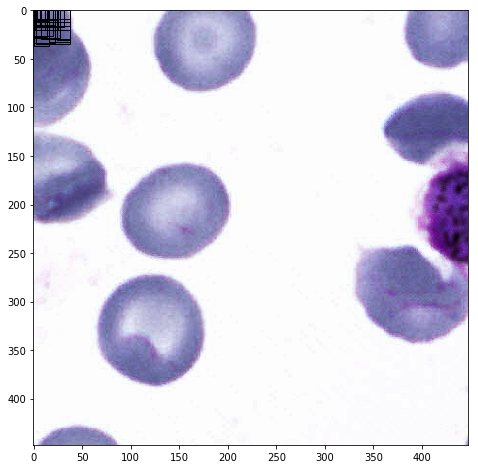

In [167]:
figure = matplotlib.pyplot.figure(figsize=(12, 8))

axis = figure.add_subplot(111, aspect="equal")

for region in R:
    patch = matplotlib.patches.Rectangle((region[0], region[1]), region[2], region[3], fill=False)

    axis.add_patch(patch)

axis.imshow(img)

In [170]:
ROIs = np.expand_dims(R[num_rois*jk:num_rois*(jk+1),:],axis=0)

# if ROIs.shape[1] == 0:
#     break

if jk == R.shape[0]//num_rois:
    #pad R
    curr_shape = ROIs.shape
    target_shape = (curr_shape[0],num_rois,curr_shape[2])
    ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
    ROIs_padded[:,:curr_shape[1],:] = ROIs
    ROIs_padded[0,curr_shape[1]:,:] = ROIs[0,0,:]
    ROIs = ROIs_padded

[P_cls, P_regr] = model_classifier.predict([F, ROIs])

P_regr = P_regr / C.std_scaling

for ii in range(P_cls.shape[1]):
    if np.max(P_cls[0,ii,:]) < 0.5:
        continue

    if np.argmax(P_cls[0,ii,:]) == (P_cls.shape[2] - 1):
        continue

    cls_name = class_mapping[np.argmax(P_cls[0,ii,:])]

    if cls_name not in bboxes:
        bboxes[cls_name] = []
        probs[cls_name] = []

    (x, y, w, h) = ROIs[0,ii,:]

    cls_num = np.argmax(P_cls[0, ii, :])
    
    print(ii)
    
    try:
        (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
    
        x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)

        bboxes[cls_name].append([16*x, 16*y, 16*(x+w), 16*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))
    except Exception:
        pass

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [135]:
np.max(P_cls[0, ii, :])

0.9980737

In [140]:
(P_cls.shape[2] - 1)

7

In [136]:
np.argmax(P_cls[0, ii, :])

7

In [175]:
all_dets = {}

for key in bboxes:
    bbox = np.array(bboxes[key])

#     new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), threshold=0.5)
    
#     for jk in range(new_boxes.shape[0]):
#         (x1,y1,x2,y2) = new_boxes[jk,:]

#         cv2.rectangle(img_scaled,(x1, y1), (x2, y2), class_to_color[key],2)

#         textLabel = '{}:{}'.format(key,int(100*new_probs[jk]))
#         if key not in all_dets:
#             all_dets[key] = 100*new_probs[jk]
#         else:
#             all_dets[key] = max(all_dets[key],100*new_probs[jk])

#         (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
#         textOrg = (x1,y1+20)

In [177]:
bboxes

{'rbc': []}